# trimming and log, normalization

We are going to use the first derivative method for trimming. The D1 profile reflects the abrupt changes in pitch values and we can set a threshold beyond which the pitch values are deemed as spuriously too high. 

That threshold is 1.6 currently (this works on normalized space with mean of 0 and std of 1).

One discovery we had is that the simple log transformation (like that of Surendran) actually doesn't preserve the relationships between pitch contours well. The log space is not behaving in the same way as the Hertz space. Here is an example of using simple log vs. using Bark scale, which is more linear in lower values and log in higher values.

## contrast between log and Bark scale: case study

### Log scale

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

def read_tab(inputfile):
    
    f=open(inputfile,'r').read().split('\n')

    time=[]
    pitch=[]
    for i in range(1,len(f)):
        line=f[i]
        if line!="":
            split=line.split('\t')
            #print split
            time.append(float(split[0]))
            pitch.append(float(split[1]))
    
    plt.plot(pitch,'gx')
    return time,pitch

def read_tab_only(inputfile):
    
    f=open(inputfile,'r').read().split('\n')

    time=[]
    pitch=[]
    for i in range(1,len(f)):
        line=f[i]
        if line!="":
            split=line.split('\t')
            #print split
            time.append(float(split[0]))
            pitch.append(float(split[1]))
    
    #plt.plot(pitch,'gx')
    return time,pitch

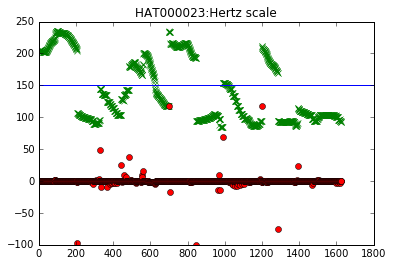

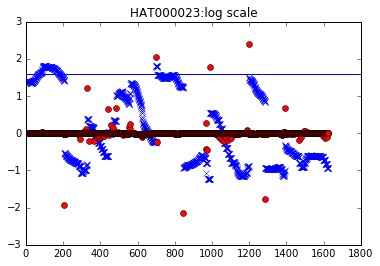

In [7]:
pickle_file='spk_mean_dict.p'
spk_mean_dict=pickle.load(open(pickle_file,'rb'))

#hertz scale
inputfile='pitch/pitcHAT000023.tab'
time,pitch=read_tab(inputfile)
der=[]
for i in range(len(time)-1):
    d1=(pitch[i+1]-pitch[i])
    der.append(d1)

plt.plot(der,'ro')
plt.axhline(y=150)
plt.title('HAT000023:Hertz scale')

#log scale
plt.figure()
spk_mean=spk_mean_dict['HAT']
pitch_norm=(np.log2(pitch)-np.log2(spk_mean))/np.std(np.log2(pitch))
plt.plot(pitch_norm,'bx')
der=[]
for i in range(len(pitch_norm)-1):
    d1=(pitch_norm[i+1]-pitch_norm[i])
    der.append(d1)

plt.plot(der,'ro')
plt.title('HAT000023:log scale')
plt.axhline(y=1.6)

in the above hertz and log scale you can see that the between the two plots the two points (out of three) near the blue horizontal line are reversed. In original scale the first one is higher than the second one, which will allow us to correctly filter out that segment as a spurious segment. The logged scale failed to do so.

### Bark scale

http://www.fon.hum.uva.nl/praat/manual/BarkSpectrogram.html

spk mean: 138.15441938
275 332.165985757
275 3.18660625793
504 186.849789127
504 1.77970795794
1084 121.715472203
1084 1.23251210449


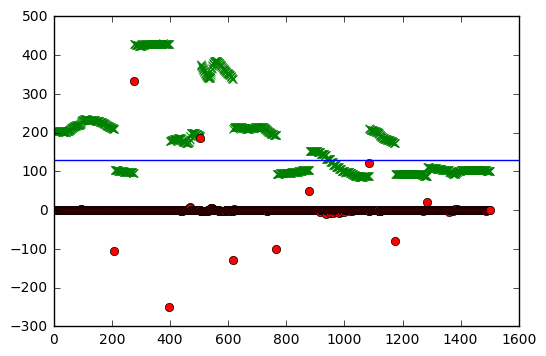

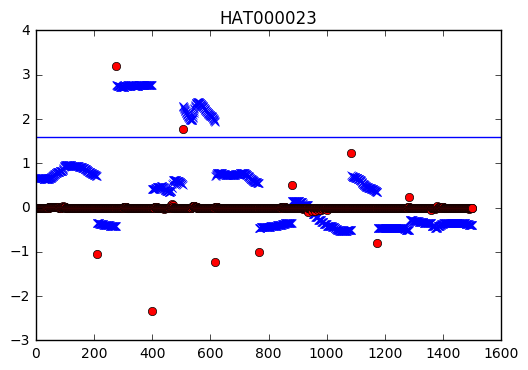

In [52]:



inputfile='pitch/pitcHAT000023.tab'
#inputfile='pitch/pitcHAT000100.tab'
#first and second plots
time,pitch=read_tab(inputfile)

der=[]
for i in range(len(time)-1):
    
    d1=(pitch[i+1]-pitch[i])
    der.append(d1)
plt.plot(der,'ro')
plt.axhline(y=130)


#third plot
plt.figure()
spk_mean=spk_mean_dict['HAT']
print 'spk mean:',spk_mean
pitch_bark=hertz_to_bark(np.array(pitch))
pitch_norm=(pitch_bark-hertz_to_bark(spk_mean))/np.std(pitch_bark)
plt.plot(pitch_norm,'bx')
der=[]
for i in range(len(pitch_norm)-1):
    d1=(pitch_norm[i+1]-pitch_norm[i])
    d=pitch[i+1]-pitch[i]
    if d>100:
        print i,d
    der.append(d1)
    if d1>1:
        print i,d1

plt.plot(der,'ro')
plt.title('HAT000023')
plt.axhline(y=1.6)

In this bark scale, in contrast, things are consistent with original and works correctly.

Overall, pitch values 1.6 or above std from the mean is considered spurious.

## sanity check

Let's check this method on more randomly selected pitch contours.

In [5]:
T=130

In [4]:

def hertz_to_bark(pitch):
    return 7.0 * np.log (pitch/650.0 + np.sqrt (1 + (pitch/650.0)**2))

In [3]:
def sanity_check(inputfile,spk):
    time,pitch=read_tab(inputfile)

    der=[]
    for i in range(len(time)-1):

        d1=(pitch[i+1]-pitch[i])
        der.append(d1)
    plt.plot(der,'ro')
    plt.axhline(y=T)
    plt.axhline(y=-T)


    #third plot
    plt.figure()
    spk_mean=spk_mean_dict[spk]
    print 'spk mean:',spk_mean
    pitch_bark=hertz_to_bark(np.array(pitch))
    pitch_norm=(pitch_bark-hertz_to_bark(spk_mean))/np.std(pitch_bark)
    plt.plot(pitch_norm,'bx')
    der=[]
    for i in range(len(pitch_norm)-1):
        d1=(pitch_norm[i+1]-pitch_norm[i])
        d=pitch[i+1]-pitch[i]
        if d>100:
            print i,d
        der.append(d1)
        if d1>1:
            print i,d1

    plt.plot(der,'ro')
    title=inputfile.split('/')[1]
    plt.title(title)
    plt.axhline(y=1.6)
    

spk mean: 118.926691942


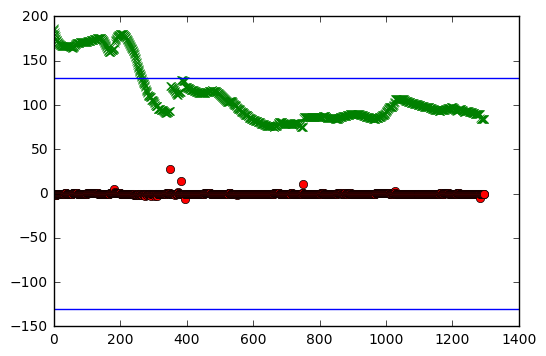

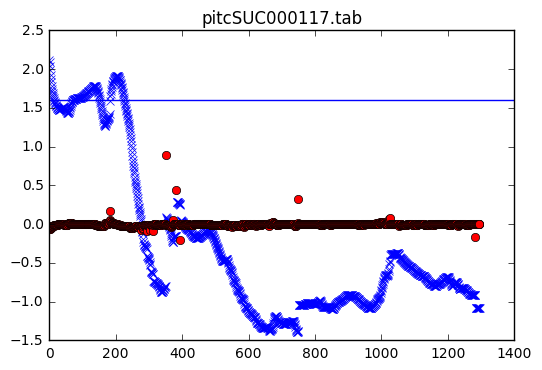

In [45]:
inputfile='pitch/pitcSUC000117.tab'
sanity_check(inputfile,'SUC')

spk mean: 120.041728765
56 297.898347756
56 2.29590372288
195 261.181562652
195 2.03216987273
381 283.060418473
381 2.18368454937


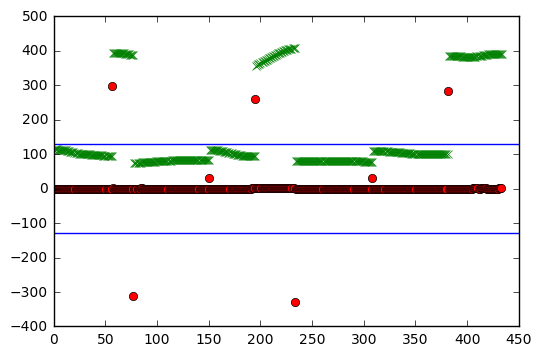

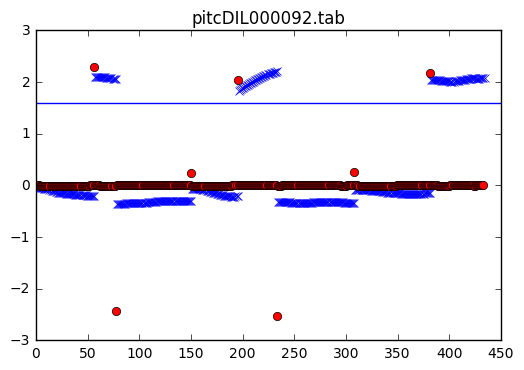

In [46]:
inputfile='pitch/pitcDIL000092.tab'
sanity_check(inputfile,"DIL")

spk mean: 120.041728765
912 1.40678429516
1348 1.24416663188


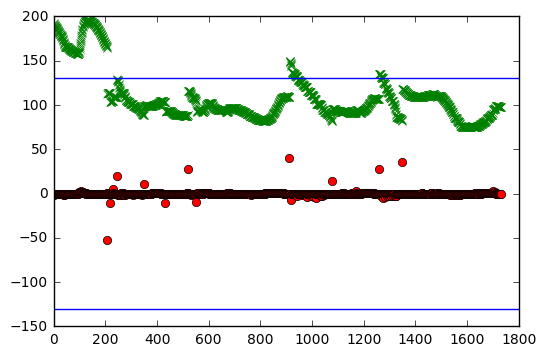

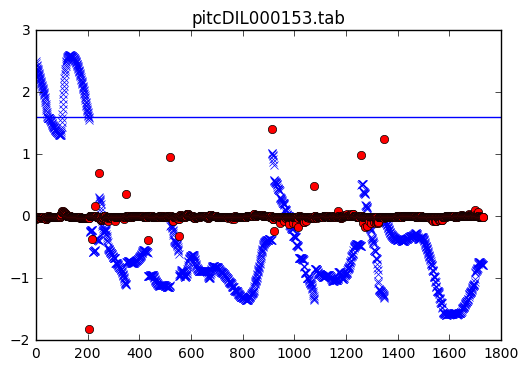

In [47]:
inputfile='pitch/pitcDIL000153.tab'
sanity_check(inputfile,"DIL")

spk mean: 138.15441938
673 192.590212868
673 2.44943247048


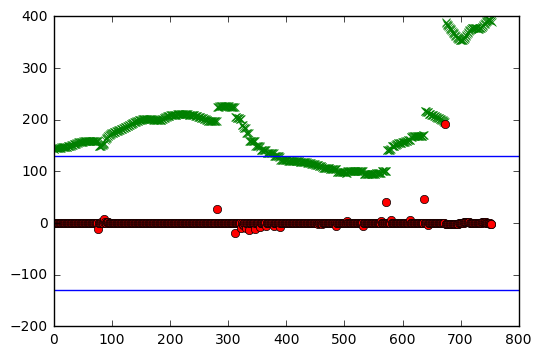

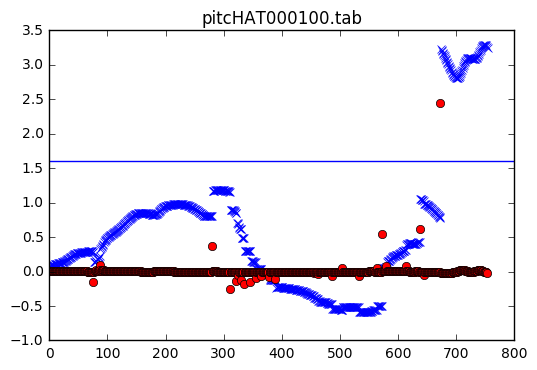

In [74]:
inputfile='pitch/pitcHAT000100.tab'
sanity_check(inputfile,"HAT")

spk mean: 138.15441938
608 503.618346957
608 4.70783219549
2184 377.42207665
2184 3.63700602683
2476 293.238991774
2476 2.90469742759


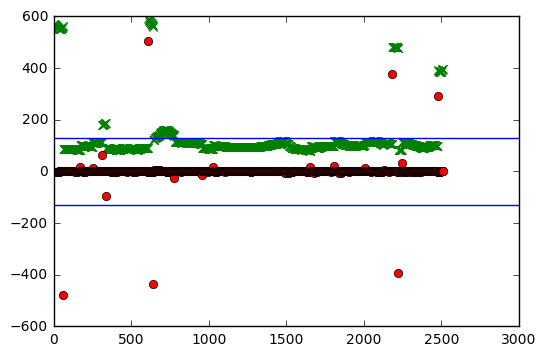

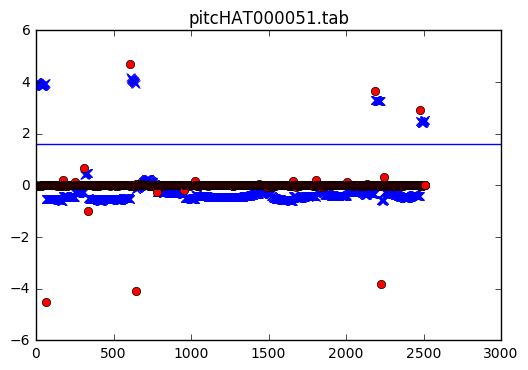

In [75]:
inputfile='pitch/pitcHAT000051.tab'
sanity_check(inputfile,"HAT")

spk mean: 122.842062388
432 1.05524785186
529 2.8918193102


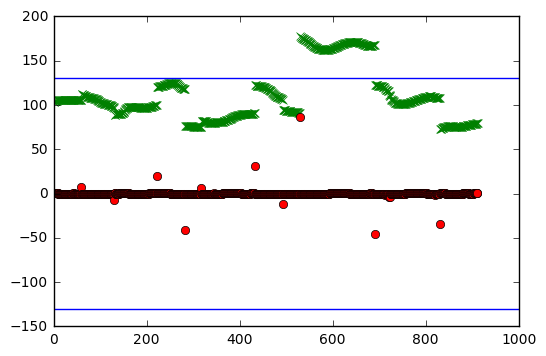

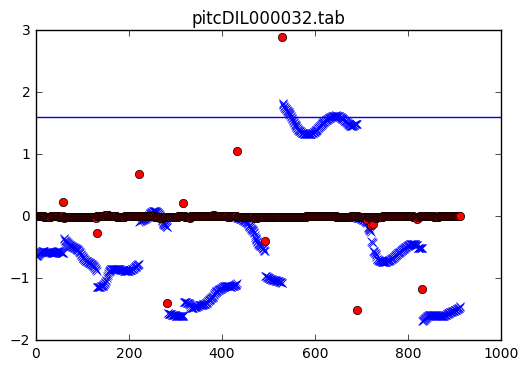

In [76]:
inputfile='pitch/pitcDIL000032.tab'
sanity_check(inputfile,"DIL")

IN this above case, it shows that the original space works well again and even bark space didn't work well in this case, due to scaling too.(that shouldn't be a spurious segment.) This is shown again in the next example.

spk mean: 122.842062388
307 1.2233831542
524 2.00331764406
802 1.08973216815
878 1.08328653804


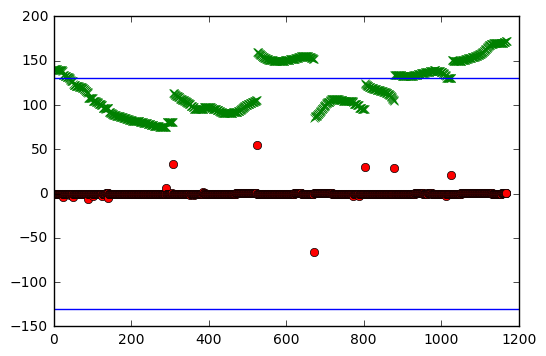

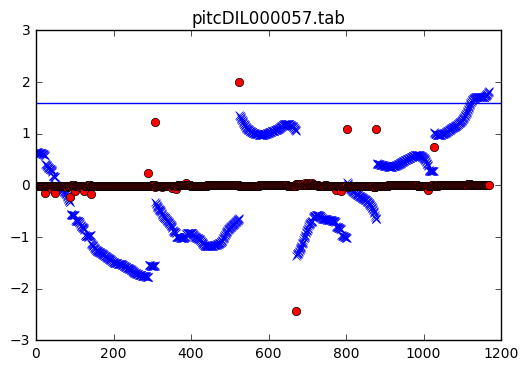

In [77]:
inputfile='pitch/pitcDIL000057.tab'
sanity_check(inputfile,"DIL")

spk mean: 122.842062388
779 304.31362515
779 5.39759693575


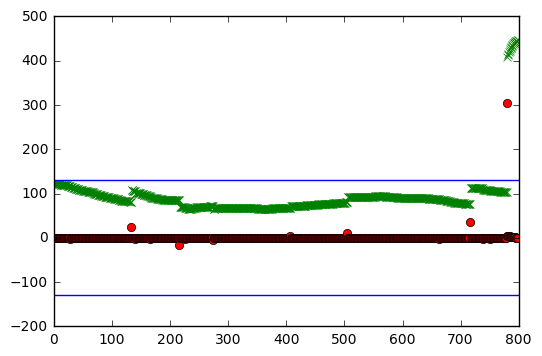

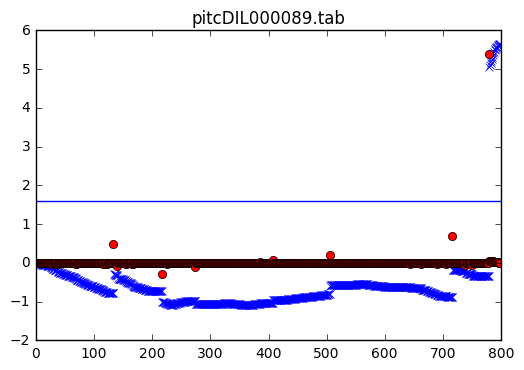

In [78]:
inputfile='pitch/pitcDIL000089.tab'
sanity_check(inputfile,"DIL")

spk mean: 122.842062388
625 2.06887917378
715 1.91854197903


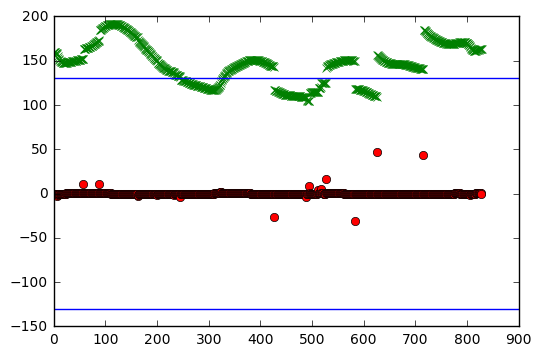

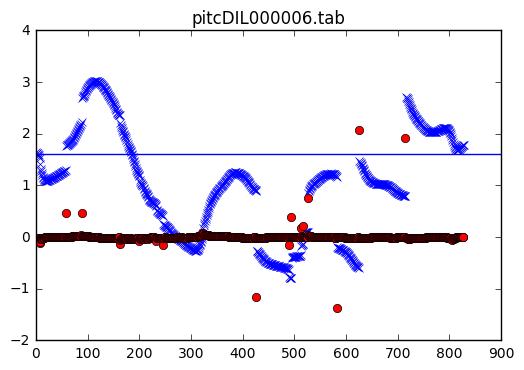

In [79]:
inputfile='pitch/pitcDIL000006.tab'
sanity_check(inputfile,"DIL")

spk mean: 125.402875196
402 2.27887220026
796 1.14027743223
910 1.06406196657


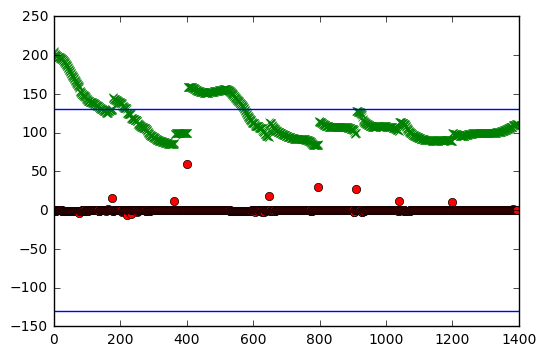

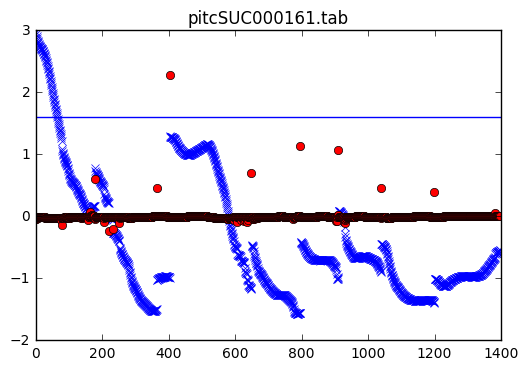

In [80]:
inputfile='pitch/pitcSUC000161.tab'
sanity_check(inputfile,"SUC")

# Conclusion

There is no doubt that the original works the best in filtering spurious pitch values. It is possible as I showed in my earlier works that Bark scale may be superior at clustering (but not classification). It's just different with various tasks.


# Implementation: segmentation, filtering

Use CHJ121 as an example:

spk mean: 156.757063336
185 211.793334954
185 2.04099574517
285 241.347553787
285 2.17750888521
683 455.379004947
683 4.14583788585
740 106.712749069
1598 126.040284761
1598 1.24855747747


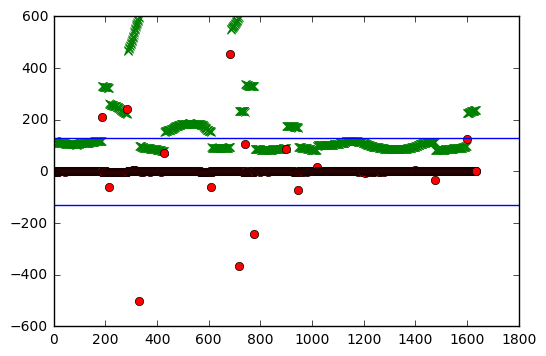

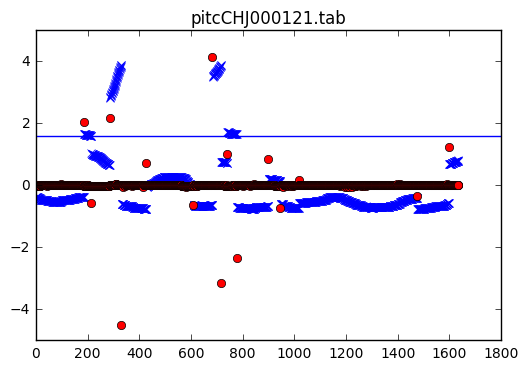

In [81]:
inputfile='pitch/pitcCHJ000121.tab'
sanity_check(inputfile,"CHJ")

In [144]:
#DIVIDE THE PITCH PROFILE INTO SEGMENTS
#FOR EACH SEGMENT, SEE IF ITS BEGINNING AND ENDING PITCH ARE OUTSIDE OF THE BELT.

inputfile='pitch/pitcCHJ000121.tab'
time,pitch=read_tab_only(inputfile)
segments_time=[[0]]
segments_pitch=[[0]]
begin=0
for i in range(1,len(time)):
    if time[i]-time[i-1]>0.0012:
        segments_pitch.append(pitch[begin:i-1])
        segments_time.append(time[begin:i-1])
        begin=i
        #print i
#print i
segments_time.append(time[begin:])
segments_pitch.append(pitch[begin:])
#print len(segments_time)


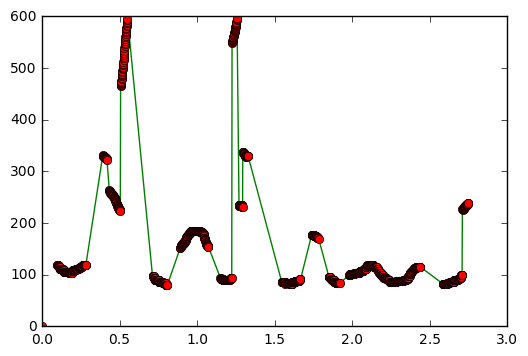

In [145]:
plt.plot(time,pitch,'g-')
for i in range(len(segments_time)):
    plt.plot(segments_time[i],segments_pitch[i],'ro')
#plt.plot(segments_time[-2],segments_pitch[-2],'gx')
#plt.plot(time[1600:],pitch[1600:],'bx')

In [164]:
len(segments_pitch)

16

In [166]:
filtered_segments_time=[]
filtered_segments_pitch=[]
spk_mean=spk_mean_dict['CHJ']
for i in range(1,len(segments_pitch)):
    beginning_d1=segments_pitch[i][0]-segments_pitch[i-1][-1]
    if i<len(segments_pitch)-1:
        ending_d1=segments_pitch[i+1][-0]-segments_pitch[i][-1]
        if not (np.abs(beginning_d1)>T and np.abs(ending_d1)>T):
            filtered_segments_time.append(segments_time[i])
            filtered_segments_pitch.append(segments_pitch[i])
    elif i==(len(segments_pitch)-1):
        if not np.abs(beginning_d1)>T:
            filtered_segments_time.append(segments_time[i])
            filtered_segments_pitch.append(segments_pitch[i])


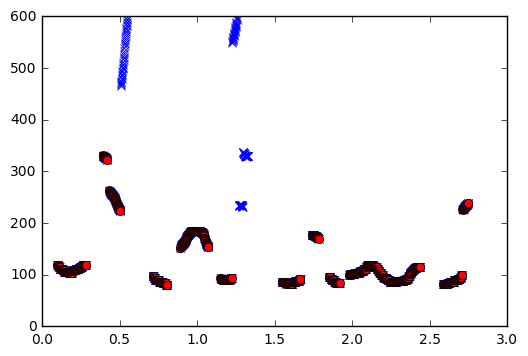

In [168]:
plt.plot(time,pitch,'x')

for i in range(len(filtered_segments_pitch)):
    plt.plot(filtered_segments_time[i],filtered_segments_pitch[i],'ro')


in this case, if we still want to get rid of the beginning two segments, then we need the value based filtering

### formalize this

In [1]:

def filter(inputfile,speaker):
    #speaker='CHJ'
    pickle_file_threshold='threshold_dict.p'

    threshold_dict=pickle.load(open(pickle_file_threshold,'rb'))
    spk_mean=spk_mean_dict[speaker]
    time,pitch=read_tab_only(inputfile)
    segments_time=[[0]]
    segments_pitch=[[spk_mean]]
    begin=0
    for i in range(1,len(time)):
        if time[i]-time[i-1]>0.0012:
            segments_pitch.append(pitch[begin:i-1])
            segments_time.append(time[begin:i-1])
            begin=i
            #print i
    #print i
    segments_time.append(time[begin:])
    segments_pitch.append(pitch[begin:])
    #print len(segments_time)
    print "len of segments:",
    for i in segments_time:
        print len(i),
    
    segment_len_threshold=45
    pitch_threshold=threshold_dict[speaker]

    #check if it segmented right
    plt.plot(time,pitch,'g-')
    for i in range(len(segments_time)):
        if i%2==0:
            color='ro'
        else:
            color='bx'
        plt.plot(segments_time[i],segments_pitch[i],color)

    #filter
    filtered_segments_time=[]
    filtered_segments_pitch=[]

    for i in range(1,len(segments_pitch)):
        #print len(segments_pitch[i]),
        if len(segments_pitch[i])<segment_len_threshold or np.mean(segments_pitch[i])>pitch_threshold:
            continue
        beginning_d1=segments_pitch[i][0]-segments_pitch[i-1][-1]
        if i<len(segments_pitch)-1:
            ending_d1=segments_pitch[i+1][-0]-segments_pitch[i][-1]
            if not (np.abs(beginning_d1)>T and np.abs(ending_d1)>T):
                filtered_segments_time.append(segments_time[i])
                filtered_segments_pitch.append(segments_pitch[i])
            elif not (np.abs(beginning_d1)>T and len(segments_pitch[i])<100):
                filtered_segments_time.append(segments_time[i])
                filtered_segments_pitch.append(segments_pitch[i])
                
        elif i==(len(segments_pitch)-1):
            if not beginning_d1>T:
                filtered_segments_time.append(segments_time[i])
                filtered_segments_pitch.append(segments_pitch[i])
    if len(segments_pitch)==2:
        filtered_segments_time=segments_time[1]
        filtered_segments_pitch=segments_pitch[1]
    #check filter results
    plt.figure()
    plt.plot(time,pitch,'x')

    for i in range(len(filtered_segments_pitch)):
        plt.plot(filtered_segments_time[i],filtered_segments_pitch[i],'ro')


len of segments: 1 282 37 297 237 75 205 199 126 101 96 15 147 64


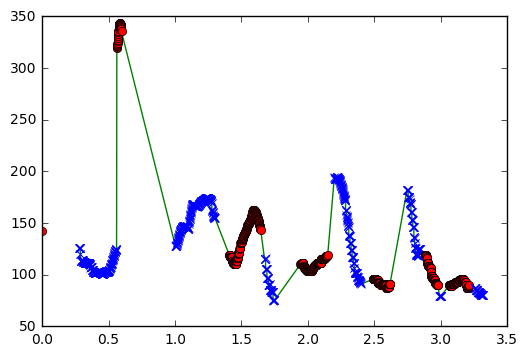

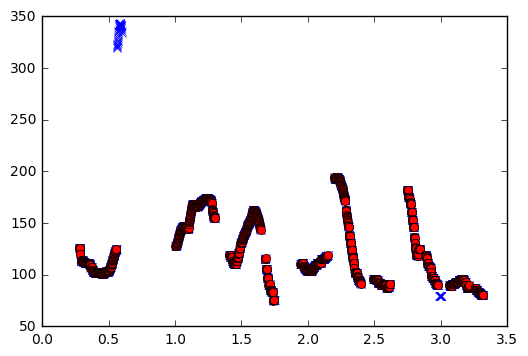

In [39]:
T=130
inputfile='pitch/pitcCHJ000056.tab'
filter(inputfile,"CHJ")

<hr>

spk mean: 142.088587903
282 194.103228103
282 4.48426118383
1138 1.79043958412
1465 2.18267572452


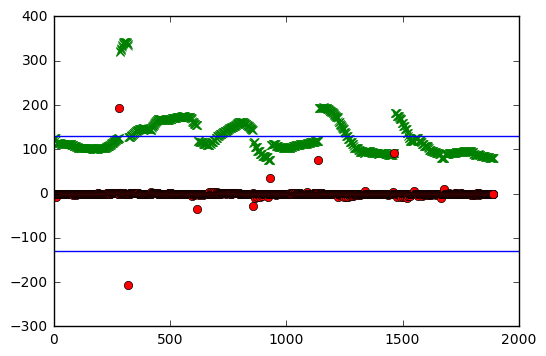

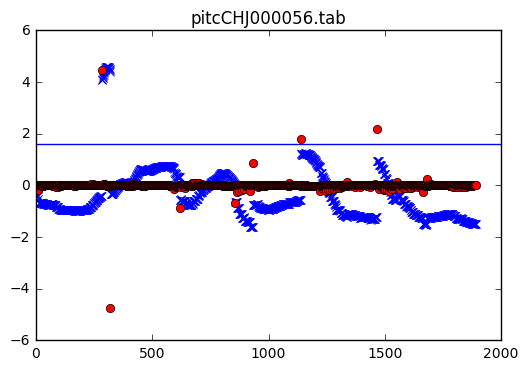

In [48]:
inputfile='pitch/pitcCHJ000056.tab'
sanity_check(inputfile,"CHJ")

len of segments: 1 179 476 128 523 253


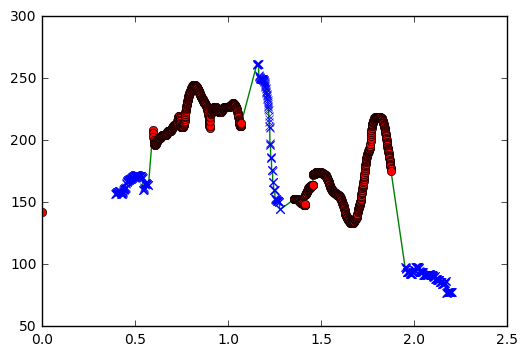

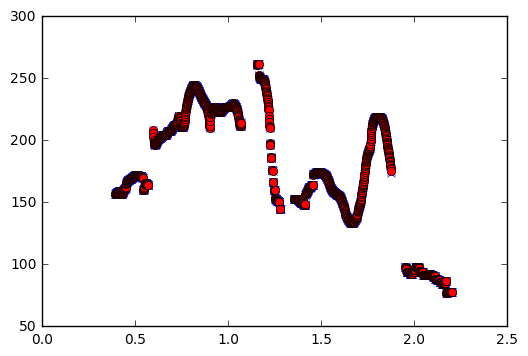

In [52]:
inputfile='pitch/pitcCHJ000126.tab'
filter(inputfile,"CHJ")

spk mean: 156.757063336
665 1.00640431728
1517 141.9925851
1517 3.02851930446


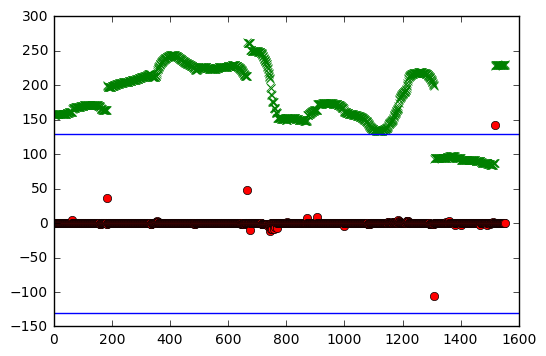

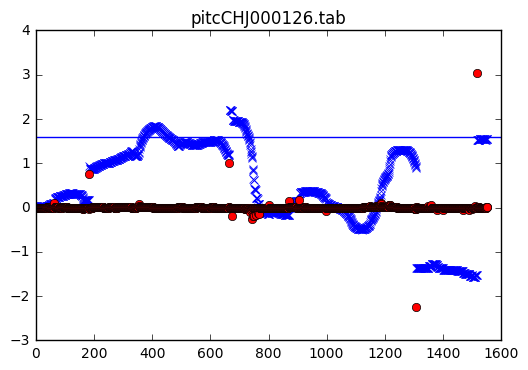

In [187]:
inputfile='pitch/pitcCHJ000126.tab'
sanity_check(inputfile,"CHJ")

spk mean: 200.248731719
53 132.456262375
53 1.2146732812
303 412.494702864
303 3.41348976025


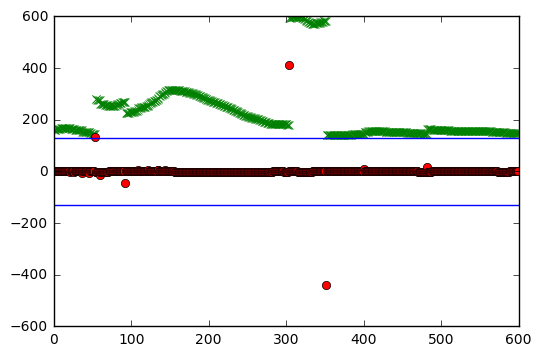

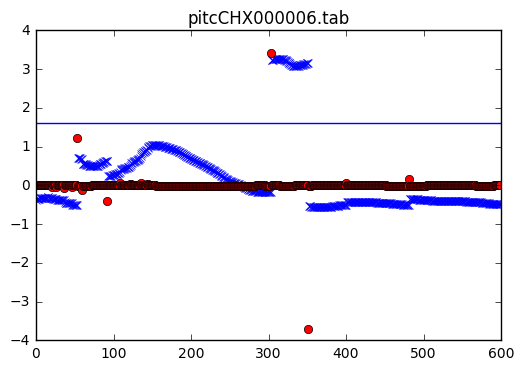

In [84]:
inputfile='pitch/pitcCHX000006.tab'
sanity_check(inputfile,"CHX")

len of segments: 1 56 26 206 45 46 75 116


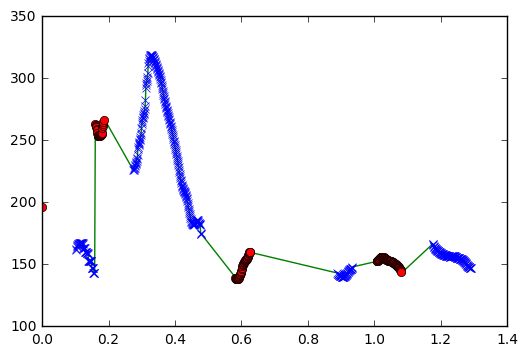

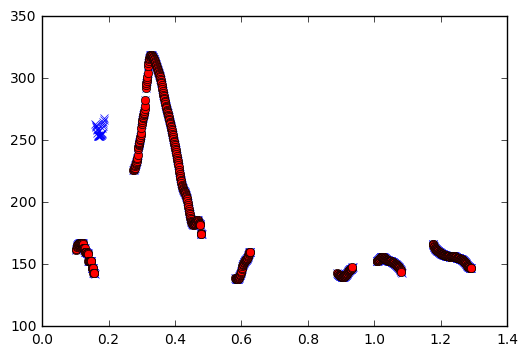

In [53]:
inputfile='pitch/pitcCHX000006.tab'
filter(inputfile,'CHX')

spk mean: 200.248731719


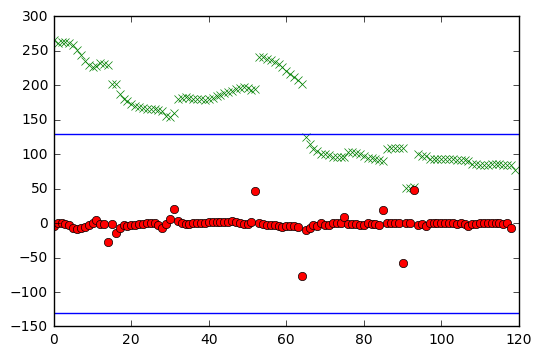

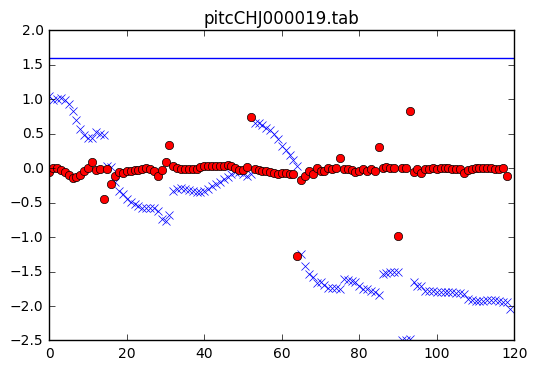

In [207]:
inputfile='pitch/pitcCHJ000019.tab'
sanity_check(inputfile,"CHX")

spk mean: 196.290434149
495 1.4226643799
985 2.25562063711
1163 1.08842177014
1669 1.44585263464
1840 1.22829151055
2018 2.64859018683
len of segments: 1 495 323 165 177 148 356 170 177 488 42 71


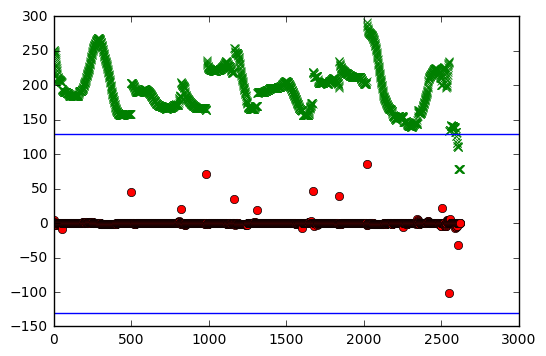

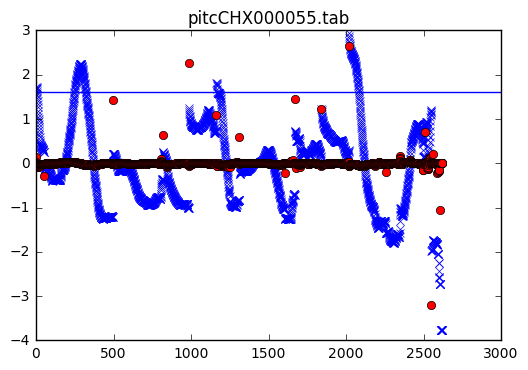

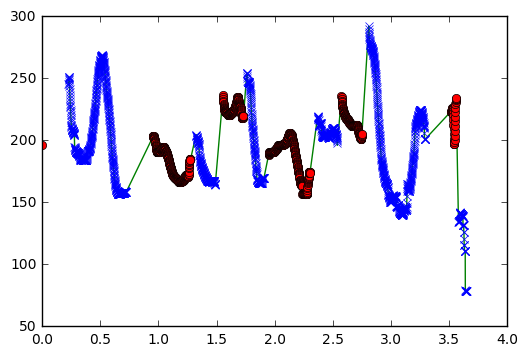

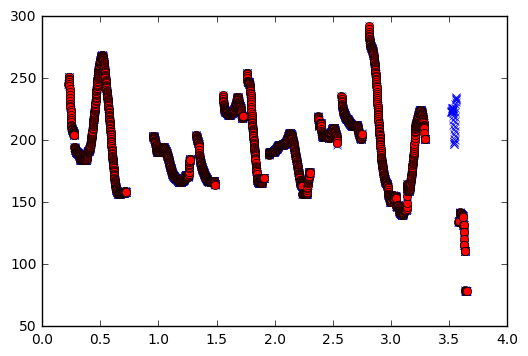

In [54]:
inputfile='pitch/pitcCHX000055.tab'
sanity_check(inputfile,"CHX")
plt.figure()
filter(inputfile,'CHX')

In [198]:
def trim(inputfile,speaker):
    pickle_file='spk_mean_dict.p'
    spk_mean_dict=pickle.load(open(pickle_file,'rb'))

    spk_mean=spk_mean_dict[speaker]
    time,pitch=read_tab_only(inputfile)
    segments_time=[[0]]
    segments_pitch=[[spk_mean]]
    begin=0
    for i in range(1,len(time)):
        if time[i]-time[i-1]>0.0012:
            segments_pitch.append(pitch[begin:i-1])
            segments_time.append(time[begin:i-1])
            begin=i
            #print i
    #print i
    segments_time.append(time[begin:])
    segments_pitch.append(pitch[begin:])
    #print len(segments_time)

    #filter
    filtered_segments_time=[]
    filtered_segments_pitch=[]
    
    for i in range(1,len(segments_pitch)):
        beginning_d1=segments_pitch[i][0]-segments_pitch[i-1][-1]
        if i<len(segments_pitch)-1:
            ending_d1=segments_pitch[i+1][-0]-segments_pitch[i][-1]
            if not (np.abs(beginning_d1)>T and np.abs(ending_d1)>T):
                filtered_segments_time.append(segments_time[i])
                filtered_segments_pitch.append(segments_pitch[i])
        elif i==(len(segments_pitch)-1):
            if not np.abs(beginning_d1)>T:
                filtered_segments_time.append(segments_time[i])
                filtered_segments_pitch.append(segments_pitch[i])
    total_filtered_time=[]
    total_filtered_pitch=[]
    for i in range(len(filtered_segments_pitch)):
        total_filtered_time.extend(filtered_segments_time[i])
        total_filtered_pitch.extend(filtered_segments_pitch[i])
    return time,total_filtered_time,pitch,total_filtered_pitch

In [201]:
a,b,c,d=trim(inputfile,"CHX")

In [204]:
print len(a),len(b),len(c),len(d)

2622 2574 2622 2574


In [205]:
print d

[248.75855641259596, 247.72657625086734, 246.68448221634995, 245.6189275820445, 244.50568991260758, 243.31108814395756, 242.00670730318222, 240.59070911329786, 239.10634142752662, 237.57107529074054, 235.91780590978192, 234.08648635934972, 232.3534167471105, 230.98549861681272, 229.87715768218658, 228.9030573669481, 227.9754302583535, 227.0271900724325, 225.99056935548458, 224.809592952443, 223.50865125677294, 222.19696924879602, 220.910698654073, 219.60439090537542, 218.30787667367667, 217.1088486196744, 215.98502613404793, 214.81304352248816, 213.4857006013753, 212.28938288540243, 211.45366720925327, 210.84095204285774, 210.34920480822666, 209.93160042259757, 209.56175461533198, 209.22501935870562, 208.91207083522832, 208.6162115848669, 208.3325663181561, 208.05722683669623, 207.78668865162973, 207.5201123490897, 207.25461534950986, 206.9887599125996, 206.72152751761993, 206.45243152839942, 206.18108621639706, 205.90675492891796, 205.62882095111442, 205.34679081570633, 205.0594504552

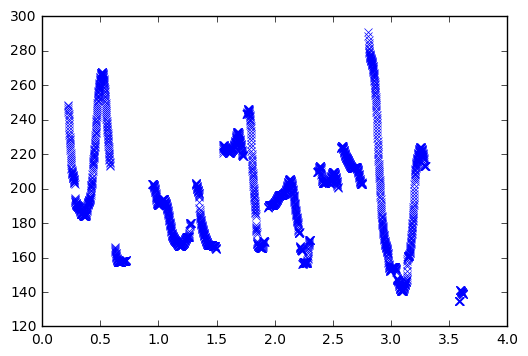

In [206]:
plt.plot(b,d,'x')

In [214]:
inputfile='pitch/pitcFAJ000461.tab'

72
456


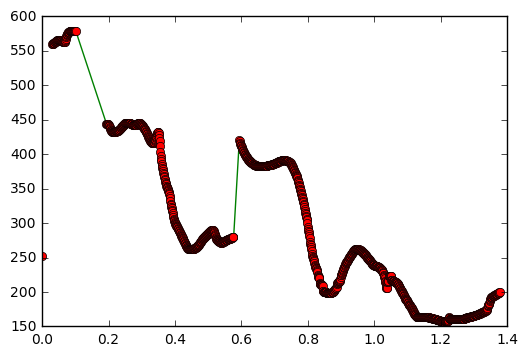

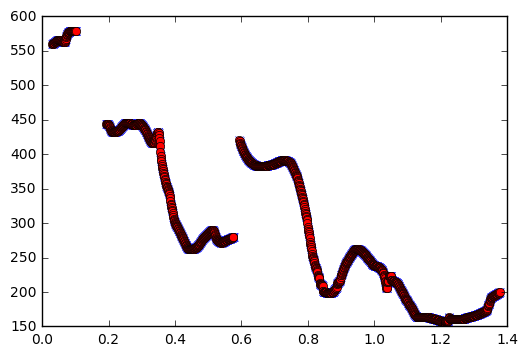

In [220]:
speaker="FAJ"
T=200
spk_mean=spk_mean_dict[speaker]
time,pitch=read_tab_only(inputfile)
segments_time=[[0]]
segments_pitch=[[spk_mean]]
begin=0
for i in range(1,len(time)):
    if time[i]-time[i-1]>0.0012:
        print i
        segments_pitch.append(pitch[begin:i-1])
        segments_time.append(time[begin:i-1])
        begin=i
        #print i
#print i
segments_time.append(time[begin:])
segments_pitch.append(pitch[begin:])
#print len(segments_time)

#check if it segmented right
plt.plot(time,pitch,'g-')
for i in range(len(segments_time)):
    plt.plot(segments_time[i],segments_pitch[i],'ro')

#filter
filtered_segments_time=[]
filtered_segments_pitch=[]

for i in range(1,len(segments_pitch)):
    beginning_d1=segments_pitch[i][0]-segments_pitch[i-1][-1]
    if i<len(segments_pitch)-1:
        ending_d1=segments_pitch[i+1][-0]-segments_pitch[i][-1]
        if not (np.abs(beginning_d1)>T and np.abs(ending_d1)>T):
            filtered_segments_time.append(segments_time[i])
            filtered_segments_pitch.append(segments_pitch[i])
    elif i==(len(segments_pitch)-1):
        if not np.abs(beginning_d1)>T:
            filtered_segments_time.append(segments_time[i])
            filtered_segments_pitch.append(segments_pitch[i])


#check filter results
plt.figure()
plt.plot(time,pitch,'x')

for i in range(len(filtered_segments_pitch)):
    plt.plot(filtered_segments_time[i],filtered_segments_pitch[i],'ro')


In [216]:
print len(filtered_segments_time)
print len(filtered_segments_pitch)

0
0


In [217]:
spk_mean_dict['FAJ']

251.68034980825323

In [218]:
len(segments_time)

4

spk mean: 223.940871697
111 1.3923626821
242 102.028760506
242 2.03124130102
1613 1.43581905775
2114 1.23854152858
2825 103.055494151
2825 2.1605165975
3282 1.21837817273
3847 1.40353999714
4075 202.773182071
4075 4.18303031911
len of segments: 1 111 130 746 289 178 154 89 160 18 128 101 710 137 234 83 424 73 65 168 58 28


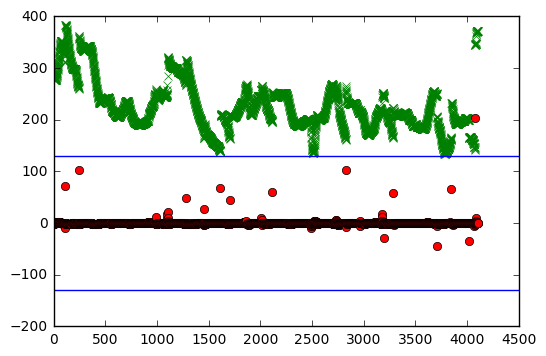

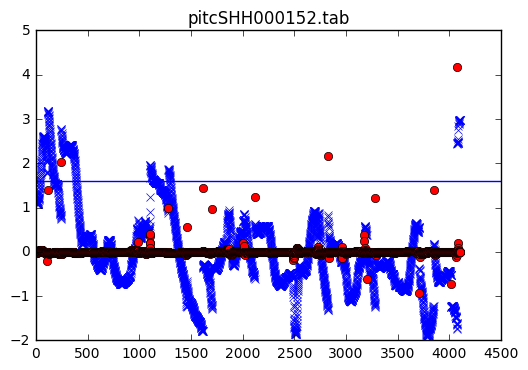

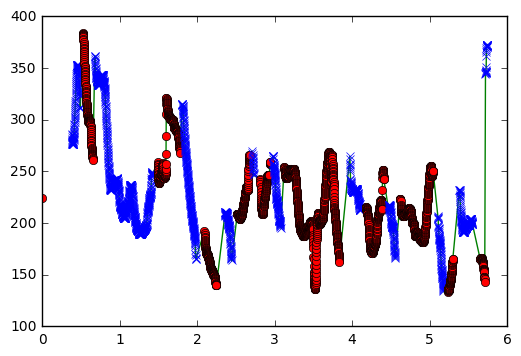

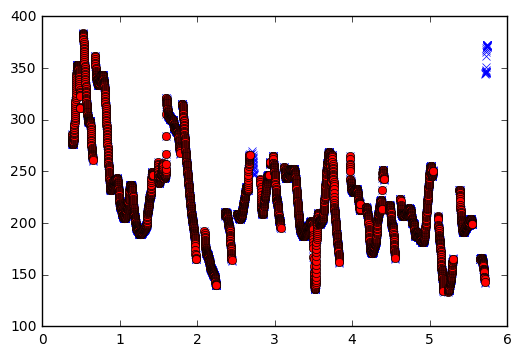

In [55]:
T=130
inputfile='pitch/pitcSHH000152.tab'
sanity_check(inputfile,"SHH")
plt.figure()
filter(inputfile,'SHH')

spk mean: 223.940871697
146 109.962520379
146 1.93970470197
316 1.22952898246
920 101.245818531
920 1.85109495944
1032 187.497416016
1032 3.28448485293
1253 1.60777502524
1480 1.03832772889
1772 1.22870962199
2180 151.131886571
2180 2.73901731025
len of segments: 1 146 190 225 73 35 149 96 111 51 168 226 84 206 183 223 35 143


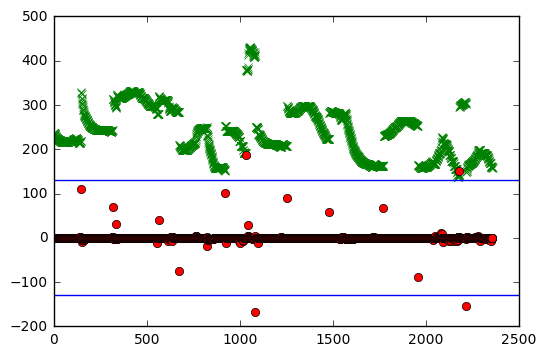

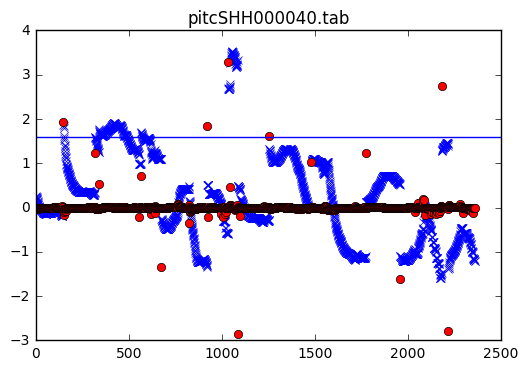

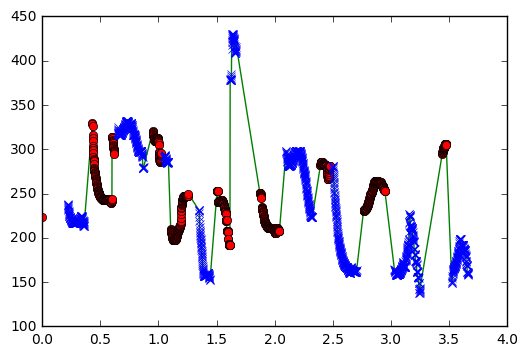

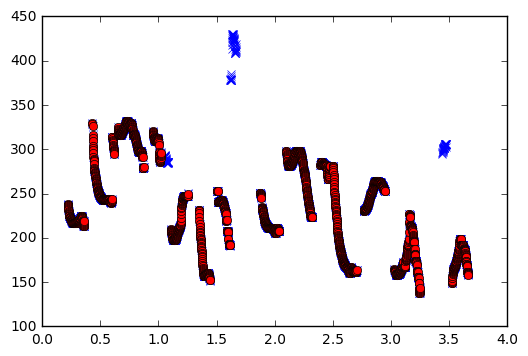

In [56]:
T=130
inputfile='pitch/pitcSHH000040.tab'
sanity_check(inputfile,"SHH")
plt.figure()
filter(inputfile,'SHH')

spk mean: 228.791856843
289 224.15435754
289 2.9623033548
1062 104.051448267
1062 1.4422621517


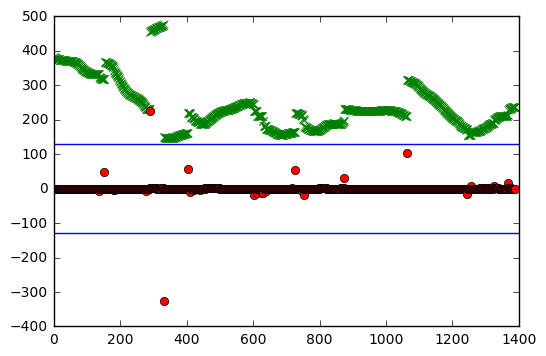

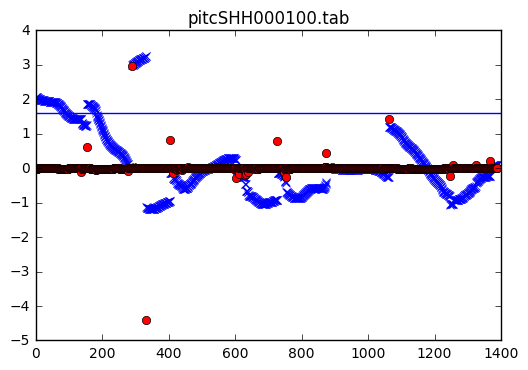

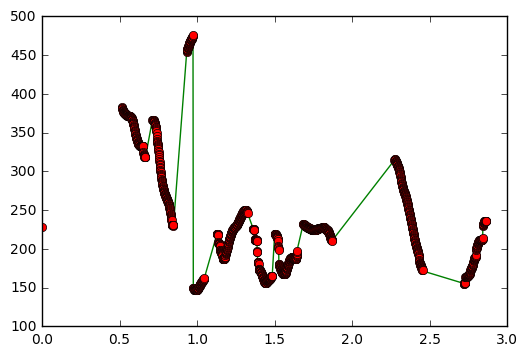

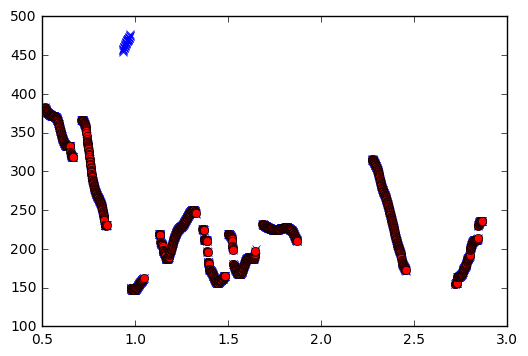

In [226]:
T=130
inputfile='pitch/pitcSHH000100.tab'
sanity_check(inputfile,"SHH")
plt.figure()
filter(inputfile,'SHH')

spk mean: 251.680349808
333 241.248724069
333 2.0695234527
1157 406.414259921
1157 3.4958699644
1321 229.270166884
1321 2.0377276254
1777 166.17266312
1777 1.51934592665
2088 355.29370494
2088 3.17271595953


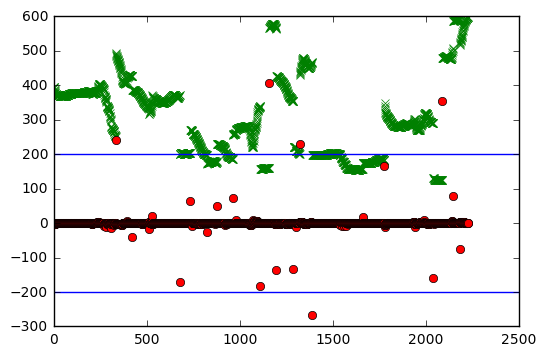

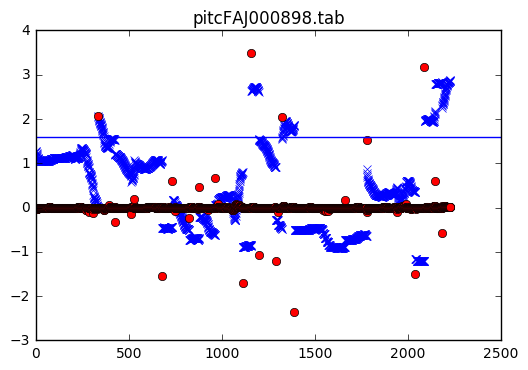

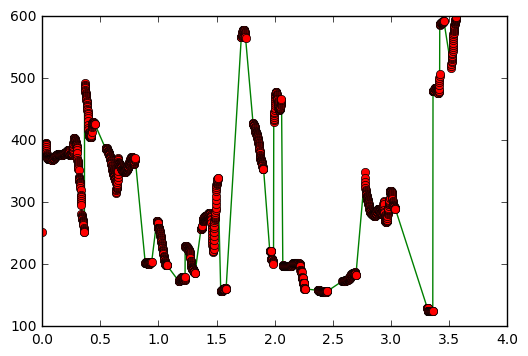

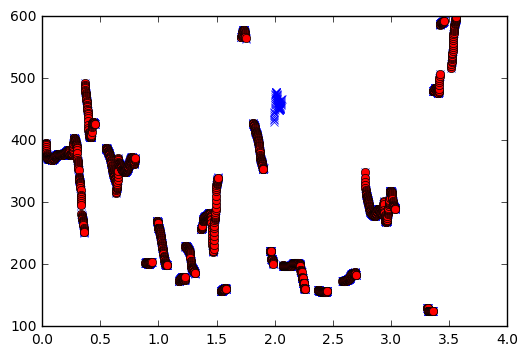

In [232]:
T=200
inputfile='pitch/pitcFAJ000898.tab'
sanity_check(inputfile,"FAJ")
plt.figure()
filter(inputfile,'FAJ')

spk mean: 125.710163838
1358 494.061234803
1358 7.35216752764


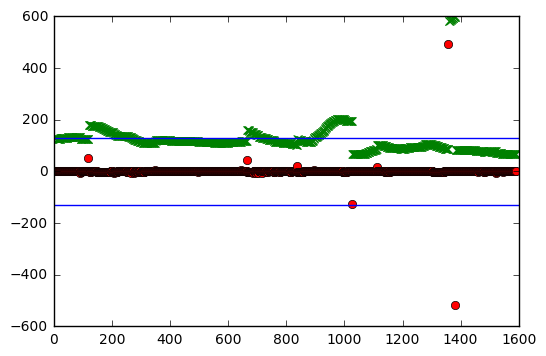

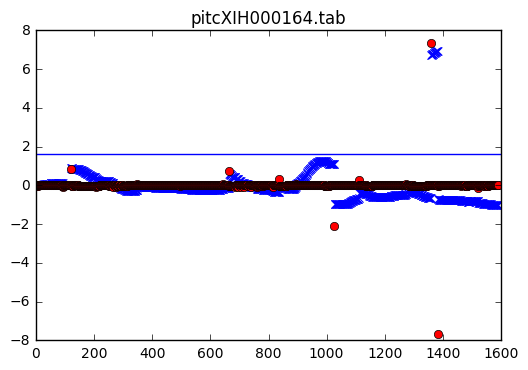

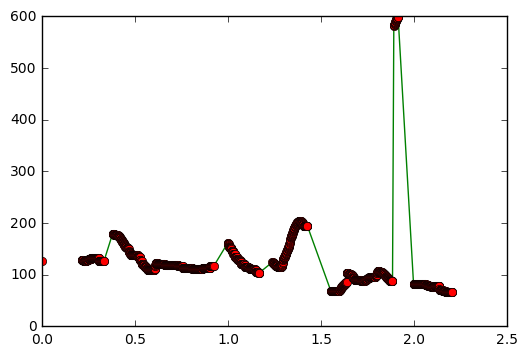

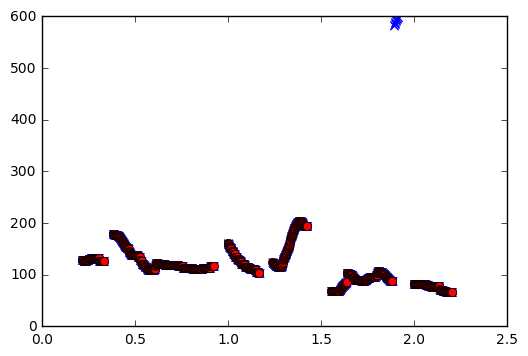

In [233]:
T=130
inputfile='pitch/pitcXIH000164.tab'
sanity_check(inputfile,"XIH")
plt.figure()
filter(inputfile,'XIH')

spk mean: 228.791856843
681 102.599735733
681 1.77181901348
1197 161.552378523
1197 2.80187482309
1327 1.45458956791


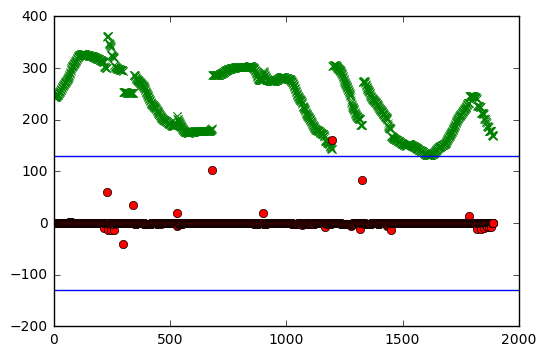

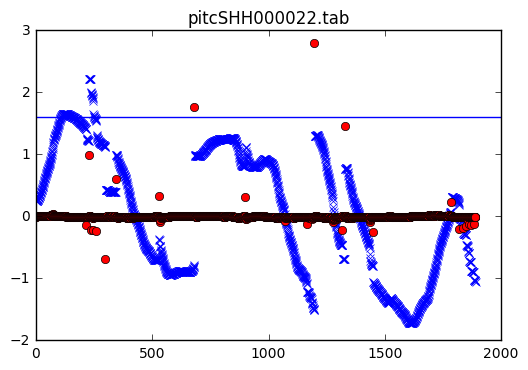

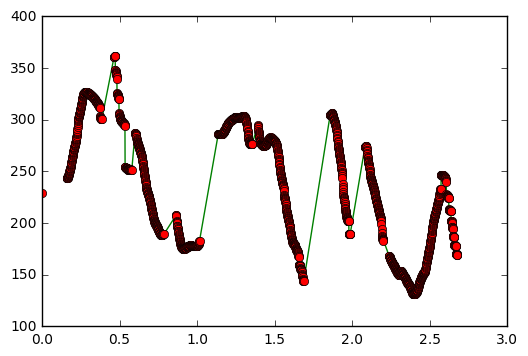

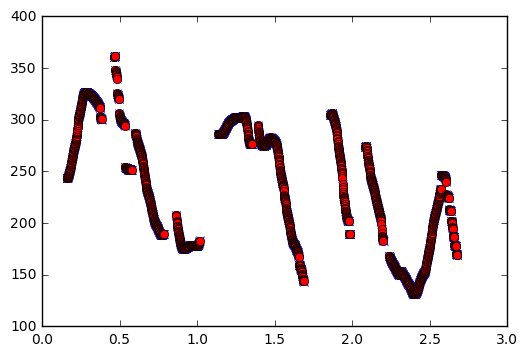

In [229]:
T=130
inputfile='pitch/pitcSHH000022.tab'
sanity_check(inputfile,"SHH")
plt.figure()
filter(inputfile,'SHH')

In [230]:
time,pitch=read_tab_only('pitch/pitcCHJ000001.tab')
ntime,npitch=read_tab_only('procd_pitch_newtrim/CHJ000001_proc.tab')
plt.plot(time,pitch,'x')
plt.plot(ntime,npitch,'ro')

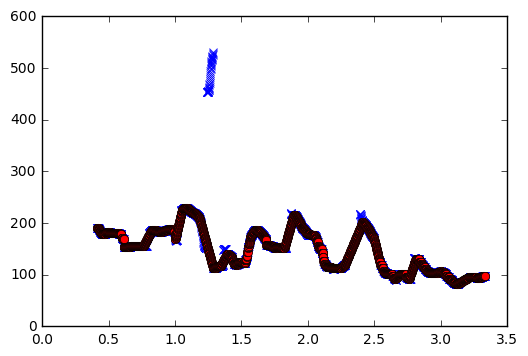

spk mean: 209.467712572
263 1.62517571929
695 170.611802356
695 3.37532376557
929 242.143987673
929 4.71727114821
1158 1.27121919641
len of segments: 1 100 162 94 125 127 82 23 84 124 38 169 19 154 107


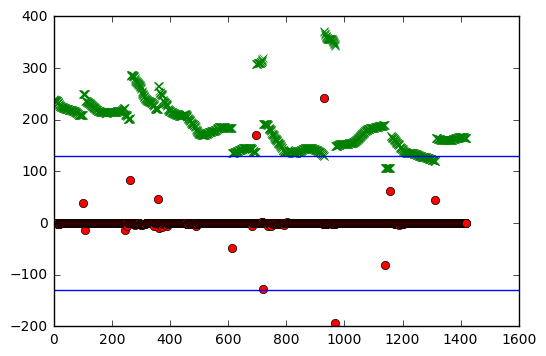

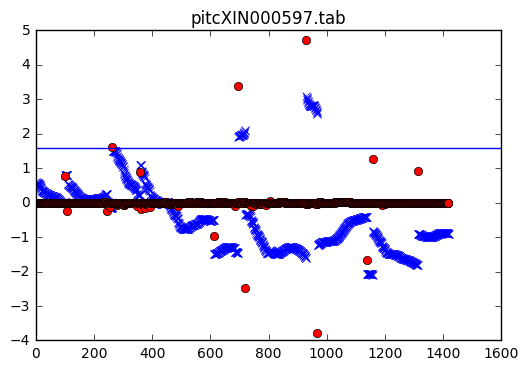

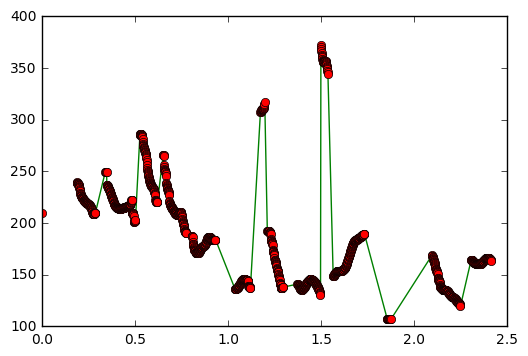

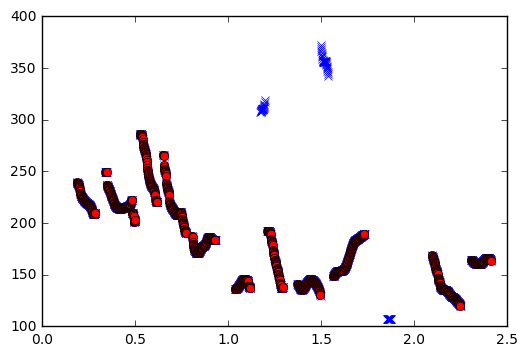

In [245]:
T=130
inputfile='pitch/pitcXIN000597.tab'
sanity_check(inputfile,"XIN")
plt.figure()
filter(inputfile,'XIN')
#Perhaps we should use a lower value than 200 for XIN? which is a high std (but not as high as 
#FAJ)

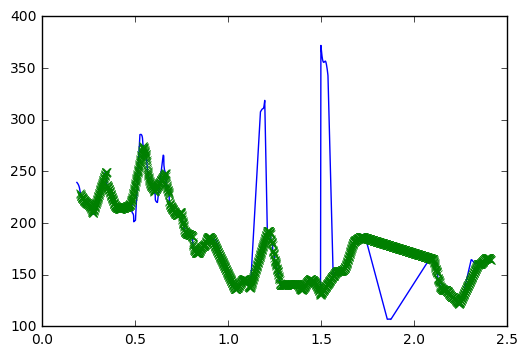

In [247]:
ot,op=read_tab_only('pitch/pitcXIN000597.tab')

t,p=read_tab_only('procd_pitch_newtrim_sec_test/XIN000597_proc.tab')
plt.plot(ot,op)
plt.plot(t,p,'gx')

spk mean: 227.76001074
len of segments: 1 588


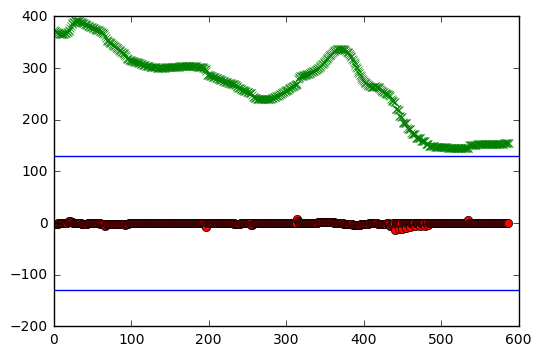

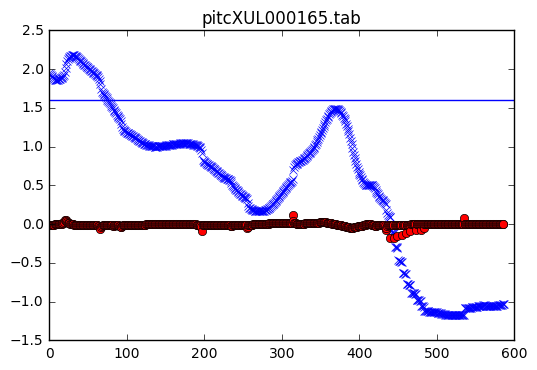

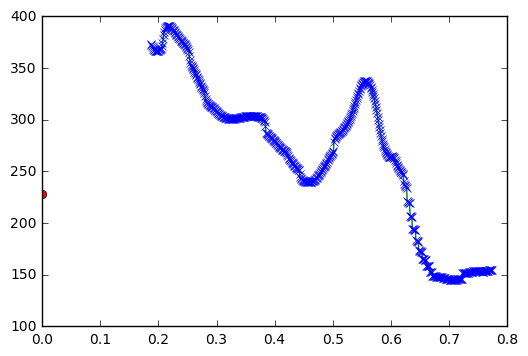

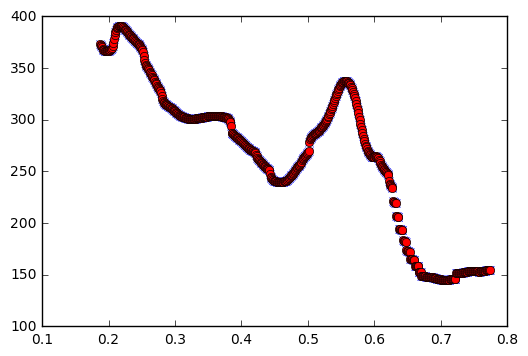

In [61]:
T=130
inputfile='pitch/pitcXUL000165.tab'
sanity_check(inputfile,"XUL")
plt.figure()
filter(inputfile,'XUL')

In [10]:
fil_std_dict=pickle.load(open('fil_std_dict.p'))

In [11]:
fil_std_dict

{'CHJ': 45.601814187946815,
 'CHX': 42.971376180996359,
 'DIL': 30.858031121112301,
 'DOH': 46.307337375259323,
 'FAJ': 82.523802012027105,
 'HAT': 36.532130748800164,
 'KOF': 53.914967048660316,
 'LIS': 34.707141787155621,
 'MAK': 34.81116108489524,
 'OUT': 35.223373251237774,
 'RUO': 58.403339588330368,
 'SHH': 50.197799160271892,
 'SUC': 22.898015029360671,
 'TIK': 43.038945617446359,
 'WAJ': 37.683699360798819,
 'XIH': 36.110000681209279,
 'XIJ': 41.439566589227226,
 'XIN': 61.526745260280677,
 'XIY': 35.276298737687313,
 'XUL': 64.228982364006455}

spk mean: 227.801231957
241 1.44024420902
578 1.19345641448
685 147.513042383
685 2.78678606282
1542 136.717573392
1542 2.53091296133
1862 1.00526367649
len of segments: 1 22 218 105 230 106 430 106 100 217 635


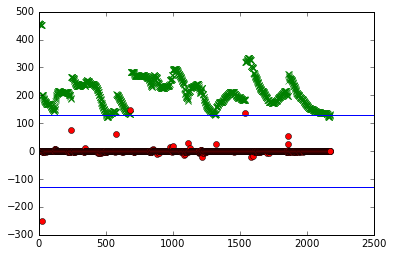

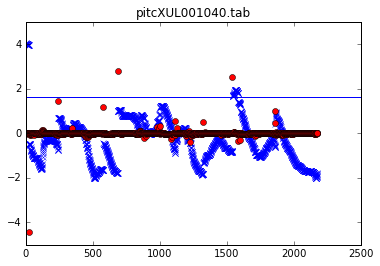

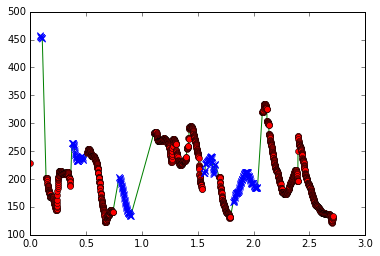

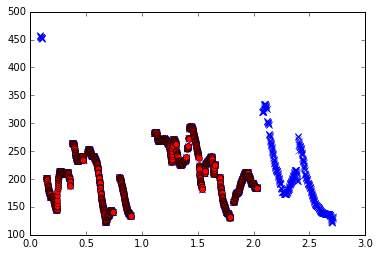

In [8]:
T=130
inputfile='pitch/pitcXUL001040.tab'
sanity_check(inputfile,"XUL")
plt.figure()
filter(inputfile,'XUL')